In [1]:
# This notebook makes setolabo samples as test samples. 
# CGBBOP
# Lung + colorectal + Gastric + Breast + brain + ovarian + prostate, all cancer type individually. 
# Also analysis of these cancer type 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
# Define a function to calculate median of the 6 closest non-NaN values
def fill_with_closest_median_or_zero(column):
    # Create a copy of the column to avoid modifying in place
    filled_column = column.copy()
    for idx in column[column.isna()].index:  # Find indices of NaN values
        # Get the 3 previous and 3 next valid (non-NaN) values
        window = column[max(0, idx - 3): idx + 4].dropna()
        if len(window) > 0:
            # Compute the median of up to 6 closest values
            filled_column[idx] = window.median()
        else:
            # Fill with 0 if no valid values are found
            filled_column[idx] = 0
    return filled_column

In [ ]:
path = 'E:/MedBank/head_model/NGS/data_shared_by_Takeshi-san/'
df_lung = pd.read_excel(path+'Lung/Lung_PRJNA842759.xlsx')
df_colo = pd.read_csv(path+'Colorectal/Colorectal_SRP411850_PRJNA909776.csv')
df_gast = pd.read_excel(path+'gastric/PRJNA946800.xlsx')
df_breast = pd.read_csv(path+'breast/Breast_PRJNA934049_forR_edit.csv')
df_seto = pd.read_csv('E:/MedBank/head_model/NGS/data_shared_by_Takeshi-san/expression_count_test_20240807.csv')
# --> new
df_brain = pd.read_excel(path+'brain/Brain tumor_Blood.xlsx')
df_ovarian = pd.read_excel(path+'ovarian/Ovarian_miRNA expression count data.xlsx')
df_prostate = pd.read_excel(path+'prostate/Prostate_miRNA expression count data.xlsx')


common_miRNA = set(df_colo['miRNA']) & set(df_gast['miRNA']) & set(df_breast['miRNA']) & set(df_brain['miRNA']) & set(df_ovarian['miRNA']) & set(df_prostate['miRNA']) & set(df_seto['gene_id'])  # & set(df_lung['miRNA'])  

df_lung = df_lung[df_lung['miRNA'].isin(common_miRNA)].sort_values(by='miRNA')
df_colo = df_colo[df_colo['miRNA'].isin(common_miRNA)].sort_values(by='miRNA')
df_gast = df_gast[df_gast['miRNA'].isin(common_miRNA)].sort_values(by='miRNA')
df_gast = df_gast.drop_duplicates(subset='miRNA', keep='first')
df_breast = df_breast[df_breast['miRNA'].isin(common_miRNA)].sort_values(by='miRNA')
df_seto = df_seto[df_seto['gene_id'].isin(common_miRNA)].sort_values(by='gene_id')
# --> new 
df_brain = df_brain[df_brain['miRNA'].isin(common_miRNA)].sort_values(by='miRNA')
df_brain = df_brain.drop_duplicates(subset='miRNA', keep='first')
df_ovarian = df_ovarian[df_ovarian['miRNA'].isin(common_miRNA)].sort_values(by='miRNA')
df_ovarian = df_ovarian.drop_duplicates(subset='miRNA', keep='first')
df_prostate = df_prostate[df_prostate['miRNA'].isin(common_miRNA)].sort_values(by='miRNA')
df_prostate = df_prostate.drop_duplicates(subset='miRNA', keep='first')




# Combine all datasets column-wise while avoiding duplicate 'miRNA' columns
combined_df = pd.concat(
    # [df_lung.set_index('miRNA'), 
     [df_colo.set_index('miRNA'), 
     df_gast.set_index('miRNA'), 
     df_breast.set_index('miRNA'),
     df_brain.set_index('miRNA'),
     df_ovarian.set_index('miRNA'),
     df_prostate.set_index('miRNA')
     ], 
    axis=1
).reset_index()

features = combined_df['miRNA']

labels_lung = [1 for _ in range(len(df_lung.columns)-1)] # All samples are cancerous (1 for lung cancer LC)

df_colo_labels = []
for col in df_colo.columns[1:]:
    if col.startswith('advanced'):
        df_colo_labels.append(2)  # Tumor only
    elif col.startswith('colorectal'):
        df_colo_labels.append(3)  # Colorectal cancer
    elif col.startswith('healthy'):
        df_colo_labels.append(4)  # Healthy control

df_gast_labels = []
for col in df_gast.columns[1:]:
    if col.startswith('case'):
        df_gast_labels.append(5)  # Gastric cancer
    elif col.startswith('control'):
        df_gast_labels.append(6)  # Healthy control

df_breast_labels = [0] * 27 + [1] * 9  # Last 9 columns are control # 0 for breast cancer # 1 for control
labels_brain = [7 for _ in range(len(df_brain.columns)-1)] # all cancerous
labels_ovarian = [8 for _ in range(len(df_ovarian.columns)-1)] # all cancerous
labels_prostate = [9 for _ in range(len(df_prostate.columns)-1)] # all cancerous

# Seto dataset labels (test set, all BC samples)
labels_seto = [0 for _ in range(5)]
# labels_train = labels_lung + df_colo_labels + df_gast_labels + df_breast_labels
labels_train = df_colo_labels + df_gast_labels + df_breast_labels + labels_brain + labels_ovarian + labels_prostate




# Transpose the DataFrames and reset their index
combined_df = combined_df.T
df_seto = df_seto.T
combined_df.reset_index(drop=True, inplace=True)
df_seto.reset_index(drop=True, inplace=True)

# Update the column names after transposing
df_seto.columns = df_seto.iloc[0].tolist()
df_seto = df_seto[1:]
combined_df.columns = combined_df.iloc[0].tolist()
combined_df = combined_df[1:]

# Assign labels to the GRE and seto datasets
combined_df['labels'] = labels_train
df_seto['labels'] = labels_seto

# No train-test split, combined_df is the full training set and df_seto is the testing set
df_train = combined_df.iloc[:, :-1]  # Features of the full training set
df_train = df_train.apply(fill_with_closest_median_or_zero)
df_test = df_seto.iloc[:, :-1]  # Features of the full testing set

# Create labels_train and labels_test
labels_train = combined_df['labels'].tolist()
labels_test = df_seto['labels'].tolist()

Correlation code 

In [5]:
def process(df, labels):
    df = df.T  # Transpose the DataFrame
    df.reset_index(drop=True, inplace=True)  # Reset the index
    df.columns = df.iloc[0].tolist()  # Set the first row as column names
    df = df[1:]  # Drop the first row after setting column names
    df['labels'] = labels  # Add labels column
    df = df.iloc[:, :-1]  # Drop the labels column (to match the original behavior)
    df = df.apply(fill_with_closest_median_or_zero)
    df = df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric
    return df
df_test = df_test.apply(pd.to_numeric, errors='coerce')

 


Plotting

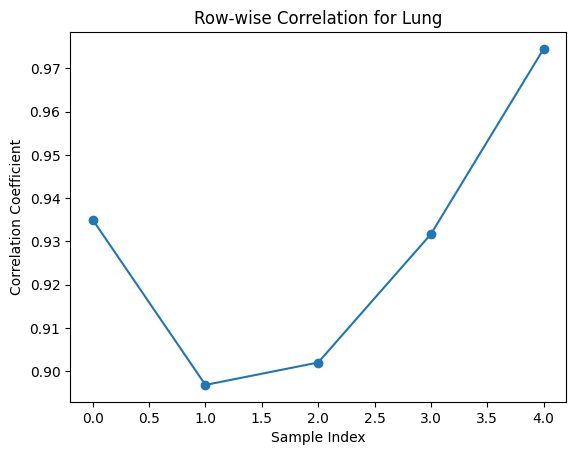

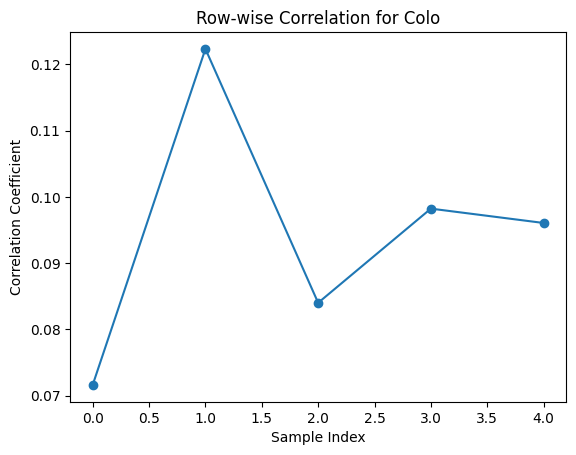

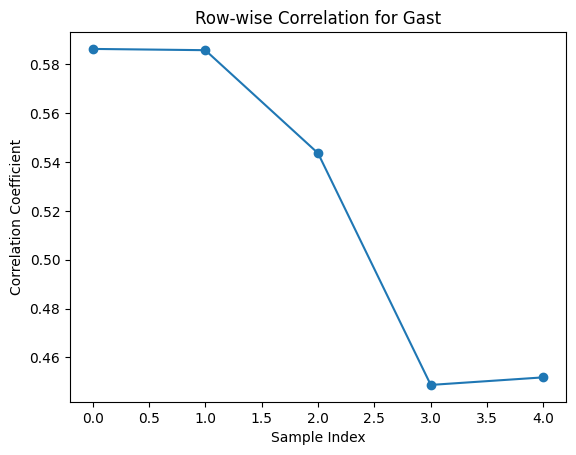

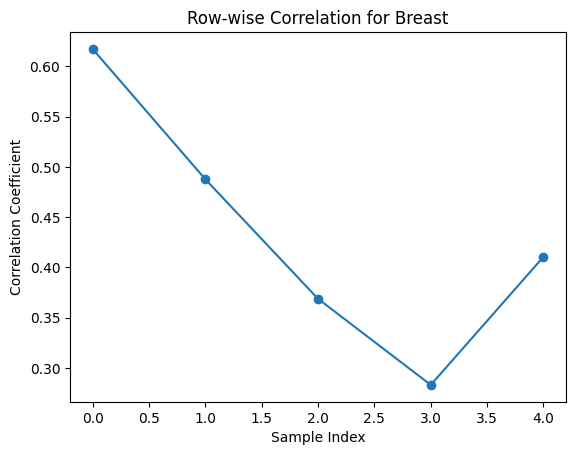

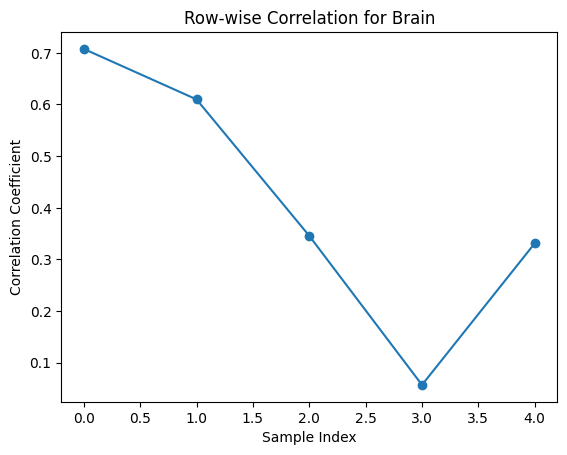

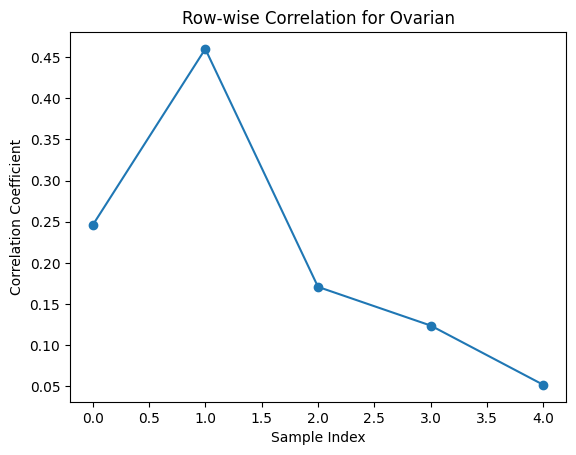

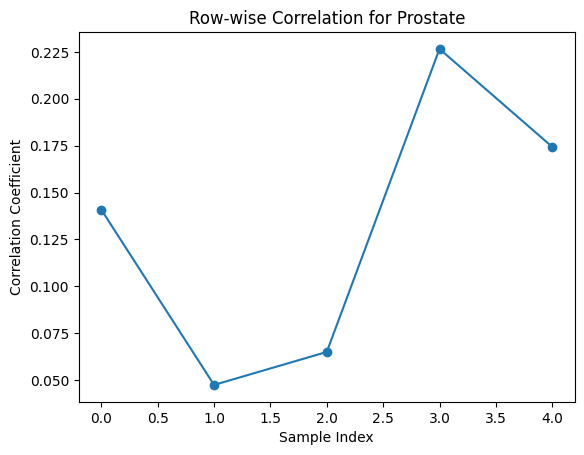

In [6]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
# List of datasets and their corresponding labels
datasets = [df_lung, df_colo, df_gast, df_breast, df_brain, df_ovarian, df_prostate]
labels_list = [labels_lung, df_colo_labels, df_gast_labels, df_breast_labels, labels_brain, labels_ovarian, labels_prostate]
dataset_names = ['Lung', 'Colo', 'Gast', 'Breast', 'Brain', 'Ovarian', 'Prostate']

# Loop through each dataset and plot the row-wise correlation
for idx, (df, labels) in enumerate(zip(datasets, labels_list)):
    processed_df = process(df, labels)

    # Align the datasets row-wise (transpose if needed for row-wise operations)
    lung_rows = processed_df.to_numpy()
    test_rows = df_test.to_numpy()

    # Ensure the row dimensions match
    min_samples = min(len(lung_rows), len(test_rows))
    lung_rows = lung_rows[:min_samples]
    test_rows = test_rows[:min_samples]

    # Compute row-wise correlations
    row_correlations = [
        pearsonr(lung_rows[i], test_rows[i])[0] for i in range(min_samples)
    ]

    # Plotting the row-wise correlation for each dataset
    plt.figure(idx)
    plt.plot(row_correlations, marker='o')
    plt.title(f"Row-wise Correlation for {dataset_names[idx]}")
    plt.xlabel("Sample Index")
    plt.ylabel("Correlation Coefficient")
    plt.show()

In [7]:
#outliers removal and normalization
def normalize_entire_dataset(df_train, df_test):
    # Combine train and test DataFrames
    combined_df = pd.concat([df_train, df_test], ignore_index=True)
    
    # Flatten the entire dataset into a single array and normalize
    min_val = combined_df.min().min()  # Minimum value across all elements
    max_val = combined_df.max().max()  # Maximum value across all elements
    
    # Avoid division by zero if all values are constant
    if max_val != min_val:
        combined_df = (combined_df - min_val) / (max_val - min_val)
    
    # Separate the DataFrames back into train and test
    df_train_normalized = combined_df.iloc[:len(df_train), :].reset_index(drop=True)
    df_test_normalized = combined_df.iloc[len(df_train):, :].reset_index(drop=True)
    
    return df_train_normalized, df_test_normalized



# df_train = normalize_dataset(df_train)
# df_test = normalize_dataset(df_test)
df_train, df_test = normalize_entire_dataset(df_train, df_test)


In [9]:
# Define NGS version as a variable
# folder_path = "E:/MedBank/head_model/head/work_dir/model_ready_folders/setolabo_samples_as_test/CGBBOP1"  # You can change this value as needed
folder_path = "E:/MedBank/head_model/NGS/data_shared_by_Takeshi-san/model_ready_folders/setolabo_samples_as_test/CGBBOP1"  # You can change this value as needed

# Paths for train and test feature vectors
file_path = f"{folder_path}/train/feature_vectors.csv"
df_train.to_csv(file_path, index=False, header=False)

file_path = f"{folder_path}/test/feature_vectors.csv"
df_test.to_csv(file_path, index=False, header=False)

##--------------------------------------------------------

# Paths for train and test labels
file_path = f"{folder_path}/train/labels.txt"
with open(file_path, 'w') as file:
    for label in labels_train:
        file.write(f"{label}\n")

file_path = f"{folder_path}/test/labels.txt"
with open(file_path, 'w') as file:
    for label in labels_test:
        file.write(f"{label}\n")

##--------------------------------------------------------

# Path for feature names
file_path = f"{folder_path}/feature_names.txt"
with open(file_path, 'w') as file:
    for label in features:
        file.write(f"{label}\n")